## Euler circuit
### An Eulerian circuit is a circuit on a graph that transverses every edge exactly once. A connected graph admits an Euleria path if and only if every vertex has odd degree. The algorithms of Fleury and Hierholzer produce Eulerian circuits in Eulerian graphs. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from itertools import combinations
import random
from constants import colors
import warnings
warnings.simplefilter(action='ignore', category=DeprecationWarning)

## Fleury algorithm
### The Fleury algorithm produces an Eulerian circuit in an Eulerian graph -multiple adges are allowed. The algorithm chooses any starting vertex and adds edges to the path trying to avoid bridges. That is, avoiding, when possible, edges that would increase the number of connected components of the graph from which transversed edges have been removed

In [2]:
def is_bridge(G, u, v):
    """
    Return True if the edge (u, v) is a bridge in graph G, otherwise return False.
    """
    # Compute the number of connected components
    num_cc = nx.number_connected_components(G)

    # Temporarily remove the edge (u, v)
    G.remove_edge(u, v)

    # Check if the number of connected components has increased
    is_bridge = nx.number_connected_components(G) > num_cc

    # Restore the edge (u, v)
    G.add_edge(u, v)

    return is_bridge


def fleury(Graph):
    """
    Return an Eulerian circuit in graph G using Fleury's algorithm.
    """
    # Check if the graph is Eulerian
    G=Graph.copy()
    if not nx.is_eulerian(G):
        return "The graph is not Eulerian"

    # Start with an arbitrary vertex
    current_vertex = list(G.nodes())[0]
    eulerian_circuit = [current_vertex]

    while G.number_of_edges() > 0:
        neighbors = list(G.neighbors(current_vertex))

        if len(neighbors) == 1:
            # If there's only one neighbor, choose it
            next_vertex = neighbors[0]
        else:
            # Prefer edges that are not bridges
            next_vertex = None
            for v in neighbors:
                if not is_bridge(G, current_vertex, v):
                    next_vertex = v
                    break

            # If all edges are bridges, choose the first one
            if next_vertex is None:
                next_vertex = neighbors[0]

        # Move to the next vertex and remove the edge from the graph
        G.remove_edge(current_vertex, next_vertex)
        eulerian_circuit.append(next_vertex)
        current_vertex = next_vertex

    return eulerian_circuit

# Example usage:
G = nx.Graph([(1, 2), (2, 3), (3, 4), (4, 5), (5, 1)])
print(fleury(G))

[1, 2, 3, 4, 5, 1]


## Animate Fleury

In [4]:
def animate_fleury(Graph):
    if not nx.is_eulerian(Graph):
        return "The graph is not Eulerian"
    G=Graph.copy()
    answer=fleury(G)
    frames=[answer[:k] for k in range(len(answer)+1)]
    
    pos = nx.circular_layout(G)  # positions for all nodes. There are other possibilities fo layout...
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        #node_colors=[np.random.choice(["black","red"]) for item in list(G.nodes)]
        color_dict=dict()
        for edge in G.edges:
            color_dict[edge]="black"
        for i in range(len(frame)-1):
            a=min(frame[i],frame[i+1])
            b=max(frame[i],frame[i+1])
            color_dict[(a,b)]="red"

        edge_colors=[color_dict[edge] for edge in list(G.edges)]
        nx.draw_networkx_edges(G, pos=pos, ax=ax,edge_color=edge_colors,width=3)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=G.nodes, edgecolors=edge_colors,ax=ax)
        

    ani = FuncAnimation(fig, update, frames=frames, repeat=True)

    # Convert the animation to a JSHTML representation
    ani_jshtml = ani.to_jshtml()
    #print(frames)
    # Display the animation
    return(HTML(ani_jshtml))

In [5]:
G=nx.Graph([(0,1),(1,2),(2,0),(2,3),(3,4),(4,2),(4,5),(5,6),(6,4)])

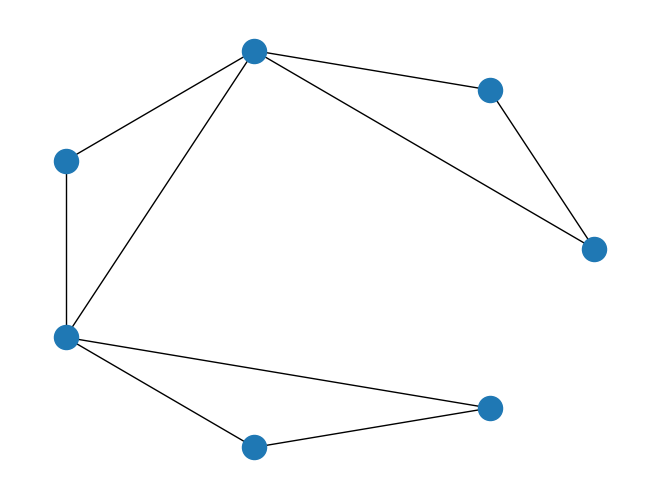

In [6]:
nx.draw(G,pos=nx.circular_layout(G))

In [14]:
for i in range(100000):
    H=nx.erdos_renyi_graph(10,0.2)
    if nx.is_eulerian(H):
        ER=H
        break

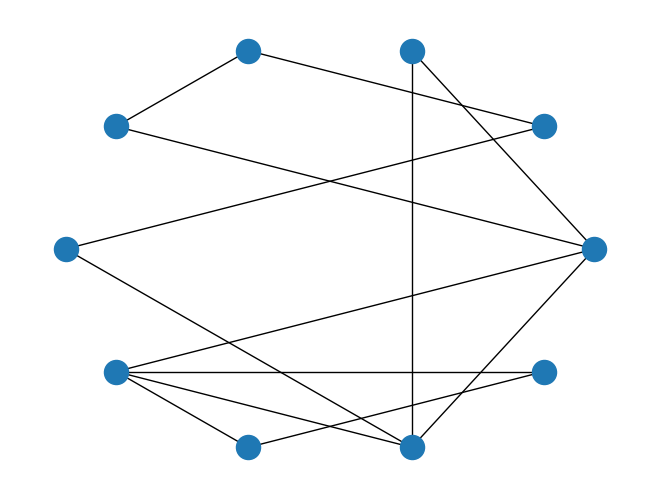

In [15]:
nx.draw(ER,pos=nx.circular_layout(ER))

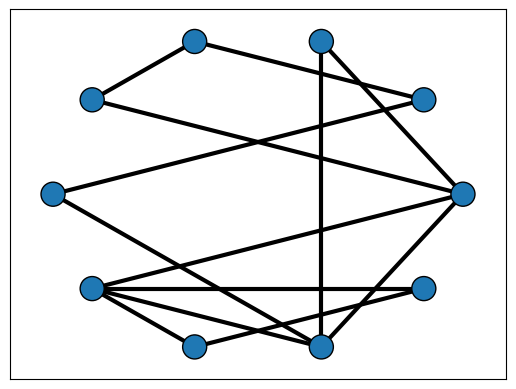

In [16]:
animate_fleury(ER)

## Hierholzer Algorithm
### This algorithm produces an Eulerian circuit in an Eulerian graph. It starts at any vertex and adds edges at random. In case a circuit cannot be continued, it starts another circuit starting at a vertex of the exhausted one, making sure that the two circuits can be combined into a larger one.


In [17]:
def find_local_circuit(Graph, start_vertex):
    """
    Returns a local circuit from the given start_vertex in graph G.
    """

    local_circuit = []
    current_vertex = start_vertex
    G=Graph.copy()
    while len(G.edges(current_vertex)) > 0:
        next_vertex = list(G.neighbors(current_vertex))[0]
        G.remove_edge(current_vertex, next_vertex)
        local_circuit.append(current_vertex)
        current_vertex = next_vertex

    local_circuit.append(current_vertex)
    if local_circuit[0]!=local_circuit[-1]:
        return "There seems to be a problem. A circuit was not found"
    return local_circuit

def hierholzer_eulerian(Graph):
    G=Graph.copy()
    """
    Returns an Eulerian circuit in Eulerian graph G using Hierholzer's algorithm.
    """
    # Check if the graph is Eulerian
    if not nx.is_eulerian(G):
        return "The graph is not Eulerian"

    # Start with an arbitrary vertex
    current_vertex = list(G.nodes())[0]
    main_circuit = find_local_circuit(G, current_vertex)
    for i in range(len(main_circuit)-1):
        G.remove_edge(main_circuit[i],main_circuit[i+1])

    # While there are unused edges, keep finding local circuits and merge them
    while len(G.edges()) > 0:
        # Find a vertex in the main circuit with unused edges
        for vertex in main_circuit:
            if len(G.edges(vertex)) > 0:
                current_vertex = vertex
                break

        # Find a local circuit from the current vertex
        local_circuit = find_local_circuit(G, current_vertex)

        # Merge the local circuit into the main circuit
        idx = main_circuit.index(current_vertex)
        main_circuit = main_circuit[:idx] + local_circuit + main_circuit[idx+1:]
        for i in range(len(local_circuit)-1):
            G.remove_edge(local_circuit[i],local_circuit[i+1])
    return main_circuit

In [18]:
hierholzer_eulerian(nx.complete_graph(11))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 8,
 6,
 9,
 7,
 10,
 6,
 4,
 7,
 5,
 8,
 4,
 9,
 5,
 10,
 4,
 2,
 5,
 3,
 6,
 2,
 7,
 3,
 8,
 2,
 9,
 3,
 10,
 2,
 0,
 3,
 1,
 4,
 0,
 5,
 1,
 6,
 0,
 7,
 1,
 8,
 0,
 9,
 1,
 10,
 0]

In [19]:
def find_all_circuits(Graph):
    """
    Returns all the circuits that need to be combined in Hierholzer's algorithm.
    """
    if not nx.is_eulerian(Graph):
         return "The graph is not Eulerian"
    G=Graph.copy()
    ans=[]
    start=list(G.nodes)[0]
    while list(G.edges):
        circuit=find_local_circuit(G,start)
        ans.append(circuit)
        N=len(circuit)
        for i in range(N-1):
            a=min(circuit[i],circuit[i+1])
            b=max(circuit[i],circuit[i+1])
            G.remove_edge(a,b)
            
        for vertex in circuit:
                if list(G.neighbors(vertex))!=[]:
                    #print(G.neighbors(vertex))
                    start=vertex#list(G.neighbors(vertex))[0]
                    break
        G.remove_nodes_from(list(nx.isolates(G)))
        #ans.append(circuit)
    return ans


In [7]:
def make_hierholzer_frames(all_circuits):
    """
    Returns frames for the Hierholzer animation
    """
    frames=[]
    N=len(all_circuits)
    for i in range(N):
        for j in range(len(all_circuits[i])+1):
            new=all_circuits[:i]+[all_circuits[i][:j]]
            frames.append(new)
    return frames


### Animate Hierholzer

In [32]:
def animate_hierholzer(Graph):
    if not nx.is_eulerian(Graph):
        return "The graph is not Eulerian"

    G=Graph.copy()
    all_circuits=find_all_circuits(G)
    frames=make_hierholzer_frames(all_circuits)
    #frames=fleury(G)
    pos = nx.circular_layout(G)  # positions for all nodes. There are other possibilities fo layout...
    fig, ax = plt.subplots()
    def update(frame):
        ax.clear()
        #node_colors=[np.random.choice(["black","red"]) for item in list(G.nodes)]
        color_dict=dict()
        for edge in G.edges:
            color_dict[edge]="black"
        color_index=0
        for cicle in frame:
            #print(color_index)
            for i in range(len(cicle)-1):
                a=min(cicle[i],cicle[i+1])
                b=max(cicle[i],cicle[i+1])
                color_dict[(a,b)]=colors[color_index]
            color_index=color_index+1

        edge_colors=[color_dict[edge] for edge in list(G.edges)]
        nx.draw_networkx_edges(G, pos=pos, ax=ax,edge_color=edge_colors,width=3)
        nx.draw_networkx_nodes(G, pos=pos, nodelist=G.nodes, edgecolors=edge_colors,ax=ax)
        

    ani = FuncAnimation(fig, update, frames=frames, repeat=True)

    # Convert the animation to a JSHTML representation
    ani_jshtml = ani.to_jshtml()
    #print(frames)
    # Display the animation
    return(HTML(ani_jshtml))

In [10]:
G=nx.complete_graph(7)

## Find an Erdos-Renyi graph that is Eulerian

In [21]:
for i in range(100000000):
    H=nx.erdos_renyi_graph(7,0.6)
    if nx.is_eulerian(H):
        ER=H
        break

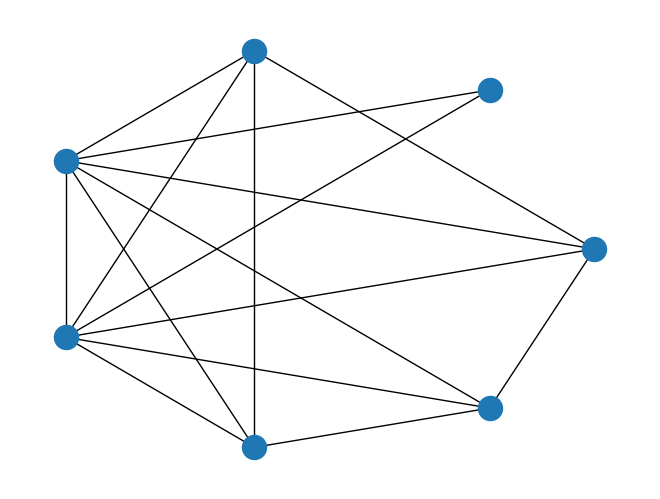

In [31]:
nx.draw(ER,pos=nx.circular_layout(ER))

## Euler Path

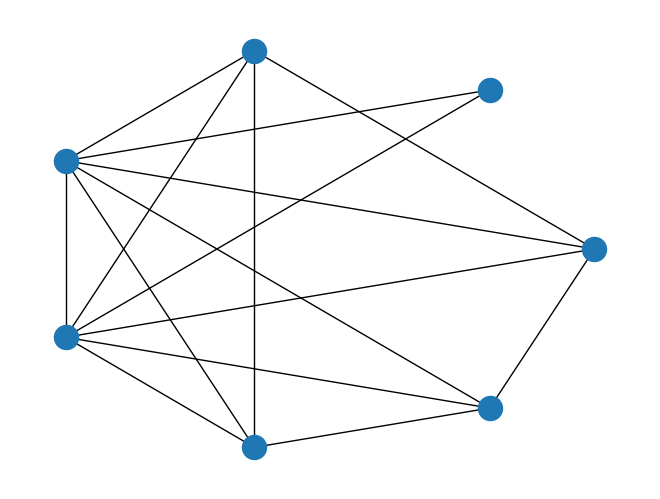

In [24]:
nx.draw(ERC,pos=nx.circular_layout(ERC))

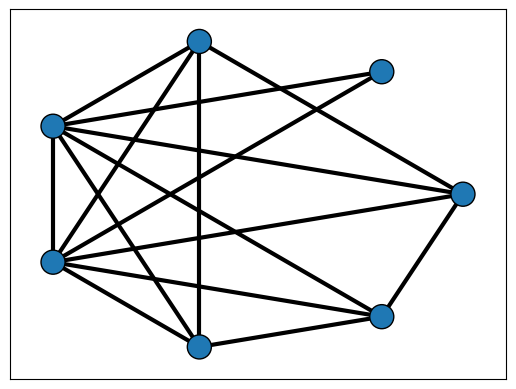

In [25]:
animate_fleury(ER
                   
                   )

In [27]:
simple=nx.Graph([(0,1),(1,2),(2,0),(2,3),(3,4),(4,2),(4,5),(5,6),(6,4)])